In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, average_precision_score, precision_recall_curve, roc_auc_score, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# CONSTANTS
DATA_PATH   = '../resources/model_datasets.npz'
GRID_PATH  = '../resources/model_results/knn_grid.npy'
MODEL_PATH  = '../resources/best_models/knn.npy'
TRAIN_MODEL = False

# K Nearest Neighbors Model

### Load the data

In [3]:
# Extract the arrays from the NPZ file
with np.load(DATA_PATH, allow_pickle=True) as npz: 
    X_train = npz['X_train'] 
    X_test = npz['X_test']
    y_train = npz['y_train']
    y_test = npz['y_test']
    Ids_train = npz['Ids_train']
    Ids_test = npz['Ids_test']
    candidates = npz['candidates']
    candidate_ids = npz['candidate_ids']
    feature_names = npz['feature_names']
    label_names = npz['label_names']
    
# Check shapes
print('Training set shape:', X_train.shape, y_train.shape)
print('Test set shape:', X_test.shape, y_test.shape)

# Label counts
pd.DataFrame({
    'count': pd.value_counts(y_train), 
    'normalized': pd.value_counts(y_train, normalize=True)}
)

Training set shape: (3000, 21) (3000,)
Test set shape: (898, 21) (898,)


,count,normalized
0,1761,0.587
1,1239,0.413


### Hyperparameters tuning

K Nearest Neighbors models are very intuitive and great in the sense that they don't try to learn some coefficients and don't make any assumption about the linearity or non-linearity of the data. Data points are simply points in an N dimensional space with a target value. Features are only used to compute the distance between data points. The predicted target value of a test data point is attributed in function of its k nearest neighbors data point target values. So, there are in fact two functions behind the scene: 

* One function that computes the distance (L1, L2, or something else if we want)
* One function that returns a predicted target value from the class of the k nearest data points (the class with the most occurrence for example)

The following hyperparameters will be tuned by grid search and 5-folds cross-validation:

* PCA number of components
* Number of nearest neighbors
* Function computing the distance: L1 and L2
* Weight function: uniform and distance

Note that the knn model doesn't support the class_weight parameter to manage the imbalance of our target variable. Aside of this notebook, I tried to downsampling the majority class but it wasn't worth the effort. Dropping 500 false positives has more negative effect than the classes imbalance.

In [4]:
# Hyperparameters
pca__n_components = [9, 12, 15, 18, None]
knn__n_neighbors = list(np.arange(3, 30)) + [35, 40, 45, 50]
knn__weights = ['uniform', 'distance']
knn__p = [1, 2]
    
# Train the model if required
if TRAIN_MODEL:
    
    # Pipeline estimator
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(random_state=0)),
        ('knn', KNeighborsClassifier(algorithm='brute'))
    ])

    # Grid parameters
    grid = ParameterGrid({
        'pca__n_components': pca__n_components,
        'knn__n_neighbors': knn__n_neighbors,
        'knn__weights': knn__weights,
        'knn__p': knn__p,
        
    })
    
    # Scorers
    average_precision_scorer = make_scorer(average_precision_score, 
                                           greater_is_better=True, 
                                           needs_proba=False,
                                           needs_threshold=True)
    
    roc_auc_scorer = make_scorer(roc_auc_score, 
                                 greater_is_better=True, 
                                 needs_threshold=True)

    # Grid Search with cross-validation
    grid_cv = GridSearchCV(
        pipe,
        grid.param_grid,
        cv=5,  # 5 folds => 2400 training, 600 validation
        scoring={
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'roc_auc': roc_auc_scorer,
            'average_precision': average_precision_scorer
        },
        refit=False,
        verbose=3
    )

    # Fit the model
    grid_cv.fit(X_train, y_train)
    
    # Save results in a numpy file
    np.save(GRID_PATH, grid_cv)
else:
    # Load the grid search results from file
    grid_cv = np.load(GRID_PATH, allow_pickle=True).item(0)

### Model selection

We can extract the results and build a dataframe to analyze them:

In [5]:
# We want to tune our models according to the precision metric
score = 'precision'

# Generic variable names to easely change the metric
r = grid_cv.cv_results_
mean_train_score = 'mean_train_' + score
mean_valid_score = 'mean_test_' + score
std_train_score  = 'std_train_' + score
std_valid_score  = 'std_test_' + score

# Create a DataFrame to analyze the grid search results
df = pd.DataFrame.from_items([
    ('n_components', r['param_pca__n_components']),
    ('n_neighbors', r['param_knn__n_neighbors']),
    ('weights', r['param_knn__weights']),
    ('p', r['param_knn__p']),
    ('mean_train_score', r[mean_train_score]),
    ('mean_valid_score', r[mean_valid_score]),
    ('delta_score', np.abs(r[mean_train_score] - r[mean_valid_score])),
    ('std_train_score', r[std_train_score]),
    ('std_valid_score', r[std_valid_score])
])

# Replace the PCA None value by the number of features
df.n_components.fillna(X_train.shape[1], inplace=True)

print('Number of models:', df.shape[0])
df.head(5)

Number of models: 620


,n_components,n_neighbors,weights,p,mean_train_score,mean_valid_score,delta_score,std_train_score,std_valid_score
0,9,3,uniform,1,0.890601,0.822504,0.068096,0.007756,0.026496
1,12,3,uniform,1,0.888882,0.819213,0.069669,0.003362,0.021143
2,15,3,uniform,1,0.884421,0.810758,0.073663,0.006939,0.025552
3,18,3,uniform,1,0.889162,0.812310,0.076852,0.003888,0.019738
4,21,3,uniform,1,0.888747,0.812644,0.076103,0.003497,0.021546


The following scatter plots will give us better insight about the results :

* mean training score VS validation standard deviation
* mean validation score VS validation standard deviation
* delta mean scores VS validation standard deviation

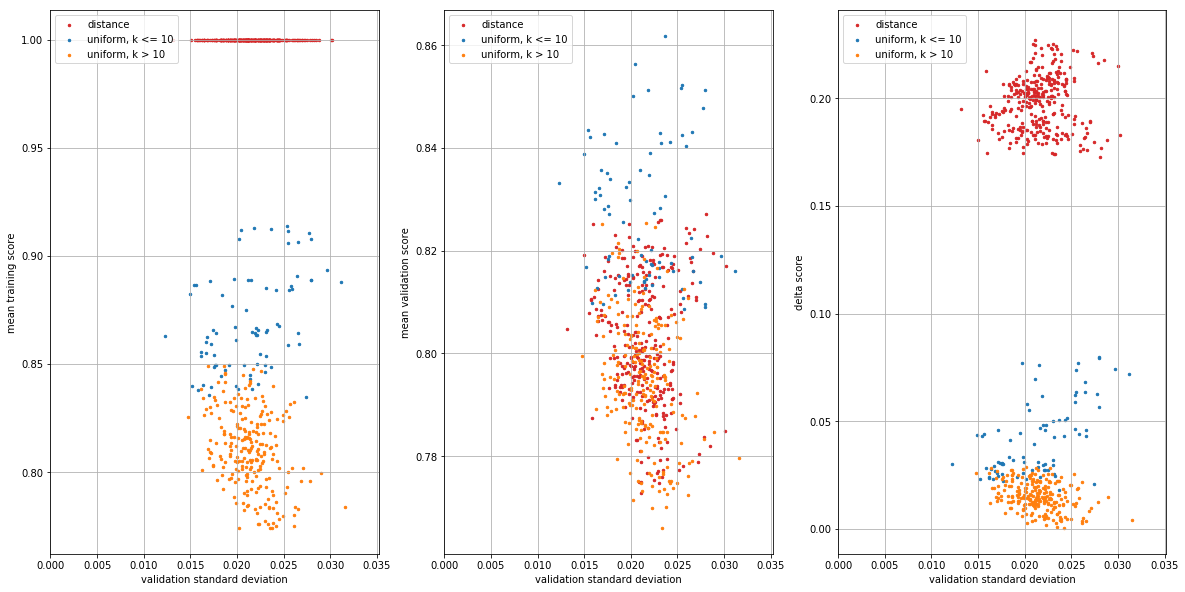

In [6]:
# Selection filters
distance_filter = (df.weights == 'distance')
n_filter = (df.n_neighbors <= 10)

# Plot vars
ylabel = ['mean training score', 'mean validation score', 'delta score']

i = 0
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
for var in ['mean_train_score', 'mean_valid_score', 'delta_score']:
    ax[i].scatter(df.std_valid_score[distance_filter], df.loc[distance_filter, var], color='C3', label='distance', s=6) 
    ax[i].scatter(df.std_valid_score[~distance_filter & n_filter], df.loc[~distance_filter & n_filter, var], color='C0', label='uniform, k <= 10', s=6)
    ax[i].scatter(df.std_valid_score[~distance_filter & ~n_filter], df.loc[~distance_filter & ~n_filter, var], color='C1', label='uniform, k > 10', s=6)
    
    ax[i].grid(axis='both')
    ax[i].set(xlabel='validation standard deviation', ylabel=ylabel[i], xlim=(0, ax[i].get_xlim()[1]))
    ax[i].legend(loc='upper left')
    i += 1

plt.show()

The models trained with the distance weighting function strongly overfit the data. It's probably due to the classes imbalance and we can safely exclude them. 

The number of neighbors has a direct impact on the bias/variance trade-off, low k values lead to highly flexible models with low bias but high variance, so more overfitting. Reciproquely, high k values lead to rigid model with high bias but low variance, so less overfitting. 

Given the results, unfortunately, all models have validation standard deviation higher than 1%.  
Our wish would be to find a model satisfying the following conditions:

* validation standard deviation <= 1.5%
* weight function = uniform
* mean validation precision >= 82%
* delta score <= 4%

In [7]:
f_std_valid = (df.std_valid_score <= 0.015)
f_delta_score = (df.delta_score <= 0.04)
f_weights = (df.weights == 'uniform')
f_score_valid = (df.mean_valid_score > 0.82)

filter = f_std_valid & f_weights & f_delta_score & f_score_valid 
selected_models = df[filter].sort_values(by='std_valid_score', ascending=True)
selected_models

,n_components,n_neighbors,weights,p,mean_train_score,mean_valid_score,delta_score,std_train_score,std_valid_score
111,12,8,uniform,2,0.86316,0.833102,0.030058,0.005969,0.012256


Only one model fullfill all the conditions, the choice is simple...

### Best model evaluation

We must now to train these model on the full training set and evaluate it on the test set :

In [8]:
# Best model hyperparameters
pca__n_components = selected_models.n_components.values[0]
knn__n_neighbors = selected_models.n_neighbors.values[0]
knn__weights = selected_models.weights.values[0]
knn__p = selected_models.p.values[0]

if TRAIN_MODEL:
    
    # Train the best model on the full training set
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=pca__n_components, random_state=0)),
        ('knn', KNeighborsClassifier(n_neighbors=knn__n_neighbors, weights=knn__weights, p=knn__p, algorithm='brute'))
    ])
    pipe.fit(X_train, y_train)

    # Save the model in a numpy file
    np.save(MODEL_PATH, pipe)
else:
    # Load the model from file
    pipe = np.load(MODEL_PATH, allow_pickle=True).item(0)    

In [9]:
# Get the predictions 
y_pred_tr = pipe.predict(X_train)
y_pred_te = pipe.predict(X_test)

# Get the contingency matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_te).ravel()

# Print the results
print('Evaluation of the best model on the test set:')
print('---------------------------------------------')
print('k-NN Precision (training set): ', np.round(precision_score(y_train, y_pred_tr), 3))
print('k-NN Tree Precision (test set) : ', np.round(precision_score(y_test, y_pred_te), 3))
print('\n')
print('Confusion Matrix (test set):')
print('----------------------------\n')
print('                Actual N\tActual P\nPredicted N\t{:3d} (TN)\t{:3d} (FN)\nPredicted P\t{:3d} (FP)\t{:3d} (TP)'.format(tn, fn, fp, tp))
print('\n')
print('Metric Summary (test set):')
print('-------------------------- ')
print('Precision : ', np.round(precision_score(y_test, y_pred_te), 3))
print('Recall    : ', np.round(recall_score(y_test, y_pred_te), 3))
print('Accuracy  : ', np.round(accuracy_score(y_test, y_pred_te), 3))
print('F1 Score  : ', np.round(f1_score(y_test, y_pred_te), 3))

Evaluation of the best model on the test set:
---------------------------------------------
k-NN Precision (training set):  0.865
k-NN Tree Precision (test set) :  0.86


Confusion Matrix (test set):
----------------------------

                Actual N	Actual P
Predicted N	473 (TN)	 38 (FN)
Predicted P	 54 (FP)	333 (TP)


Metric Summary (test set):
-------------------------- 
Precision :  0.86
Recall    :  0.898
Accuracy  :  0.898
F1 Score  :  0.879


The training and test precision scores are close indicating that the model generalizes well the data. The test validation score is even better than predicted by cross-validation.

This model is clearly better than the baseline models and the decision tree but has lower precision than the random forest model, but higher recall. With a precision score of 86% and a recall of 90%, this knn model appears to be a well balanced, intuitive and performing model.

Compared to the random forest model, it has predicted 20 True Positives and 14 False Positives more.